In [315]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


 Чтение данных. Данные взяты из отчета [Дашбоард продаж AB](https://powerbi.data.lmru.tech/reports/powerbi/%D0%9E%D1%82%D1%87%D0%B5%D1%82%D1%8B%20Power%20BI/%D0%9B%D0%9C%20%D0%9F%D0%A0%D0%9E/%D0%94%D0%B0%D1%88%D0%B1%D0%BE%D1%80%D0%B4%20%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B6%D0%B8%20%D0%90%D0%92). <br>
 Данные взяты только по продажам через b2b портал


Описание данных 
- acive_clients - активная клиентская база
- gmv - объём продаж , руб
- gmv_per_customer - средний gmv на клиента 
- gmv_units - количество проданных единиц товара
- average_bill - средний чек
- number_orders - количество заказов
- year - год
- month - месяц
- week - неделя
- date - дата



In [183]:
gmv = pd.read_excel('et/gmv .xlsx', skiprows=2)
active_clients = pd.read_excel('et/active_clients_base.xlsx', skiprows=2)
gmv_per_customer = pd.read_excel('et/gmv_per_customer.xlsx', skiprows=2)
gmv_units = pd.read_excel('et/gmv_units.xlsx', skiprows=2)
average_bill = pd.read_excel('et/mean_check.xlsx', skiprows=2)
number_orders = pd.read_excel('et/voluem_.orders.xlsx', skiprows=2)


Информация о датафрейме

In [184]:
print(f'Тип данных: '
      f'\n{gmv.dtypes}'
      f'\nShape: {gmv.shape}'
      f'\n Nan:'
      f'\n {gmv.isna().sum()}')

Тип данных: 
Год                    int64
Месяц                float64
Неделя                object
Дата          datetime64[ns]
Показатель           float64
dtype: object
Shape: (594, 5)
 Nan:
 Год           0
Месяц         0
Неделя        0
Дата          0
Показатель    0
dtype: int64


In [185]:
gmv.tail(10)

,Год,Месяц,Неделя,Дата,Показатель
584,2024,2024.08,2024.w34,2024-08-22,5832042.50
585,2024,2024.08,2024.w34,2024-08-23,5562394.46
586,2024,2024.08,2024.w34,2024-08-24,2761331.70
587,2024,2024.08,2024.w34,2024-08-25,2181533.39
588,2024,2024.08,2024.w35,2024-08-26,4735097.24
589,2024,2024.08,2024.w35,2024-08-27,6350600.56
590,2024,2024.08,2024.w35,2024-08-28,6111320.69
591,2024,2024.08,2024.w35,2024-08-29,6521139.29
592,2024,2024.08,2024.w35,2024-08-30,5493522.97
593,2024,2024.08,2024.w35,2024-08-31,2813324.65


Заменим названия столбцов и агрегируем данные

In [186]:
def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    df_name = [k for k, v in globals().items() if id(v) == id(df)][0]
    df.rename(columns={'Год' : 'year', 'Месяц' : 'month', 'Неделя' : 'week', 'Дата' : 'date', 'Показатель' : df_name}, inplace=True)
    return df

In [187]:
rename_columns(gmv)
rename_columns(active_clients)
rename_columns(gmv_per_customer)
rename_columns(gmv_units)
rename_columns(average_bill)
rename_columns(number_orders)

,year,month,week,date,number_orders
0,2023,2023.01,2023.w02,2023-01-11,4
1,2023,2023.01,2023.w02,2023-01-12,1
2,2023,2023.01,2023.w02,2023-01-13,3
3,2023,2023.01,2023.w03,2023-01-16,6
4,2023,2023.01,2023.w03,2023-01-17,13
...,...,...,...,...,...
589,2024,2024.08,2024.w35,2024-08-27,392
590,2024,2024.08,2024.w35,2024-08-28,382
591,2024,2024.08,2024.w35,2024-08-29,347
592,2024,2024.08,2024.w35,2024-08-30,344


In [188]:
df_merged = pd.merge(active_clients, gmv, on=['year','month','week','date'], how='outer')

In [189]:
df_merged = pd.merge(df_merged, gmv_per_customer, on=['year','month','week','date'], how='outer')
df_merged = pd.merge(df_merged, gmv_units, on=['year','month','week','date'], how='outer')
df_merged = pd.merge(df_merged, average_bill, on=['year','month','week','date'], how='outer')
df_merged = pd.merge(df_merged, number_orders, on=['year','month','week','date'], how='outer')

In [190]:
df_merged.head()

,year,month,week,date,active_clients,gmv,gmv_per_customer,gmv_units,average_bill,number_orders
0,2023,2023.01,2023.w02,2023-01-11,3,49960.0,16653.333333,59.0,12490.000000,4
1,2023,2023.01,2023.w02,2023-01-12,1,3905.0,3905.000000,27.0,3905.000000,1
2,2023,2023.01,2023.w02,2023-01-13,2,23048.0,11524.000000,199.0,7682.666667,3
3,2023,2023.01,2023.w03,2023-01-16,4,65217.0,16304.250000,161.0,10869.500000,6
4,2023,2023.01,2023.w03,2023-01-17,5,187437.0,37487.400000,642.0,14418.230769,13


In [191]:
print(f'Тип данных: '
      f'\n{df_merged.dtypes}'
      f'\nShape: {df_merged.shape}'
      f'\n Nan:'
      f'\n {df_merged.isna().sum()}')

Тип данных: 
year                         int64
month                      float64
week                        object
date                datetime64[ns]
active_clients               int64
gmv                        float64
gmv_per_customer           float64
gmv_units                  float64
average_bill               float64
number_orders                int64
dtype: object
Shape: (594, 10)
 Nan:
 year                0
month               0
week                0
date                0
active_clients      0
gmv                 0
gmv_per_customer    0
gmv_units           0
average_bill        0
number_orders       0
dtype: int64


In [194]:
df_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
year,594.0,2023.409091,2023.0,2023.0,2023.0,2024.0,2024.0,0.49208
month,594.0,2023.467492,2023.01,2023.06,2023.11,2024.04,2024.08,0.482083
date,594,2023-11-07 20:55:45.454545408,2023-01-11 00:00:00,2023-06-12 06:00:00,2023-11-07 12:00:00,2024-04-04 18:00:00,2024-08-31 00:00:00,NaN
active_clients,594.0,74.698653,1.0,28.0,64.5,113.0,198.0,52.83164
gmv,594.0,2383888.694259,1266.0,828349.4325,2004397.035,3569723.235,7859251.65,1838354.235018
gmv_per_customer,594.0,30739.952853,1266.0,25494.477724,30490.367891,35519.47402,117388.275,10726.628085
gmv_units,594.0,7579.464508,2.0,2613.75,6435.0,11411.75,44383.0,5970.139033
average_bill,594.0,19286.909409,1266.0,15528.852814,17976.183425,21431.428118,92224.03625,7504.60685
number_orders,594.0,130.260943,1.0,42.0,106.0,203.75,392.0,101.595373


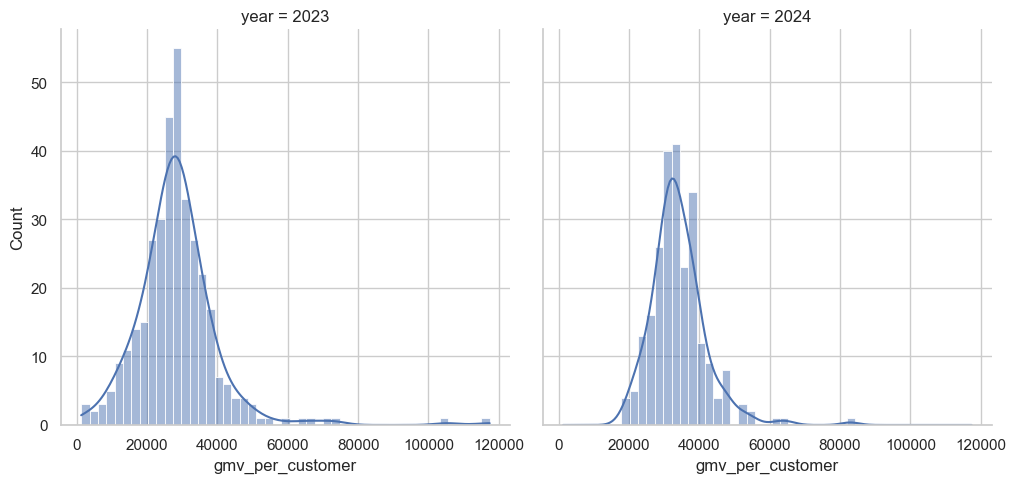

In [313]:
sns.displot(data=df_merged, x="gmv_per_customer", kde=True, col="year", col_wrap=3)


In [260]:
df_merged.columns.to_list()

['year',
 'month',
 'week',
 'date',
 'active_clients',
 'gmv',
 'gmv_per_customer',
 'gmv_units',
 'average_bill',
 'number_orders']

Получим массив признаков и разобьем на тестовую и обучающую выборки

In [314]:
X.dtypes

active_clients        int64
gmv_per_customer    float64
gmv_units           float64
average_bill        float64
number_orders         int64
dtype: object

In [263]:
X = df_merged[['active_clients', 'gmv_per_customer', 'gmv_units', 'average_bill', 'number_orders']]

In [264]:
y = df_merged['gmv']

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [284]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [286]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [287]:
y_pred = rf.predict(X_test)

Метрики оценки модели

In [288]:
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

MSE: 19717146543.94


In [297]:
print(f'R-squared: {rf.score(X_test, y_test):.2f}')


R-squared: 0.99


In [300]:
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae:.2f}') # Mean Absolute Error (mae)

MAE: 93542.14


In [301]:
df_merged.loc[df_merged['year'] == 2024].sort_values(by='date', ascending=False).head(3)

,year,month,week,date,active_clients,gmv,gmv_per_customer,gmv_units,average_bill,number_orders
593,2024,2024.08,2024.w35,2024-08-31,68,2813324.65,41372.421324,5760.0,24896.678319,113
592,2024,2024.08,2024.w35,2024-08-30,168,5493522.97,32699.541488,17560.8,16394.817442,344
591,2024,2024.08,2024.w35,2024-08-29,175,6521139.29,37263.653086,16297.5,18862.103718,347


Предсказание прогноза с помощью новых данных

In [317]:
new_data = pd.DataFrame({'active_clients': [100], 'gmv_per_customer': [45000], 'gmv_units': [6000], 'average_bill': [26000], 'number_orders': [120]})
new_pred = rf.predict(new_data)
print(f'Прогноз  значения GMV: {new_pred[0]:.2f}')

Прогноз  значения GMV: 3371820.63
